# **Regression: Covid-19 Risk Prediction Notebook**

## Objectives

Fit and evaluate a regression model to predict the risk level for a Covid-19 patient based on their age and pre-existing health conditions.

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict Risk level of patient
* Labels map
* Feature Importance Plot 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study'

---

## Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/covid-19-dataset.csv")
df['DIED'] = df['DIED'].map({'Yes': 1, 'No': 0})
df = df.drop(labels=['USMER', 'MEDICAL_UNIT'], axis=1)

print(df.shape)
df.head(3)

(62236, 16)


,SEX,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DIED
0,Male,No,No,76,No,No,No,No,Yes,Yes,No,No,No,No,No,0
1,Male,No,Yes,91,Yes,No,No,No,Yes,No,No,No,No,No,No,0
2,Male,No,Yes,39,No,No,No,No,No,No,No,No,No,No,Yes,1


---

#### Split Train Test Set

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(['DIED'], axis=1)
y = df['DIED']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (49788, 15) (49788,) 
* Test set: (12448, 15) (12448,)


### ML Pipeline: Regressor

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary',
            variables=['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA',
                       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
                       'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']
        )),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
            variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])
    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Hyperparameter Optimization

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

class HyperparameterOptimizationSearch(BaseEstimator):
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

### Grid Search CV - Sklearn

In [8]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__max_iter': [100, 200]
    },
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

### Run Grid Search

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

                    estimator min_score mean_score max_score std_score  \
16  GradientBoostingRegressor    0.1601   0.163906  0.168607  0.002929   
14        ExtraTreesRegressor  0.156578   0.161011  0.165709  0.002981   
12      DecisionTreeRegressor  0.156578    0.16101  0.165709  0.002974   
13      RandomForestRegressor  0.156304   0.160965  0.165652  0.003019   
15          AdaBoostRegressor  0.156799   0.160084  0.164321  0.002845   
17               XGBRegressor  0.120535   0.123844  0.127833  0.002495   
1          LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
11         LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
10         LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
0          LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
8          LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
7          LogisticRegression -0.284394  -0.270391 -0.262576  0.008429   
6          LogisticRegression -0.28439

### Evaluate the Best Model

In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

best_model = grid_search_summary.iloc[0, 0]
print("Best Model:", best_model)
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_

regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Best Model: GradientBoostingRegressor
Model Evaluation 

* Train Set
R2 Score: 0.167
Mean Absolute Error: 0.407
Mean Squared Error: 0.203
Root Mean Squared Error: 0.451


* Test Set
R2 Score: 0.165
Mean Absolute Error: 0.408
Mean Squared Error: 0.204
Root Mean Squared Error: 0.452




### Save the Model and Artifacts

In [12]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_severity/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/regressor_pipeline.pkl")
print(f'Model saved at {file_path}/regressor_pipeline.pkl')

X_train.to_csv(f"{file_path}/X_train.csv", index=False)
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_severity/v1'
Model saved at outputs/ml_pipeline/predict_severity/v1/regressor_pipeline.pkl


### Assess Feature Importance

* These are the 2 most important features in descending order. The model was trained on them: 
['INTUBED', 'AGE']


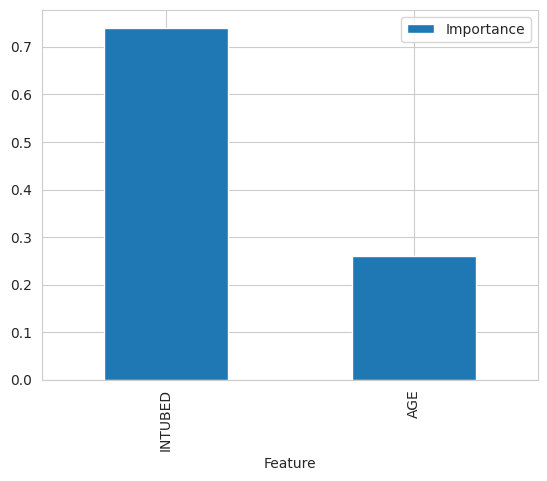

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

columns_after_data_cleaning_feat_eng = X_train.columns

df_feature_importance = pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_}
).sort_values(by='Importance', ascending=False)

print(f"* These are the {len(df_feature_importance)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

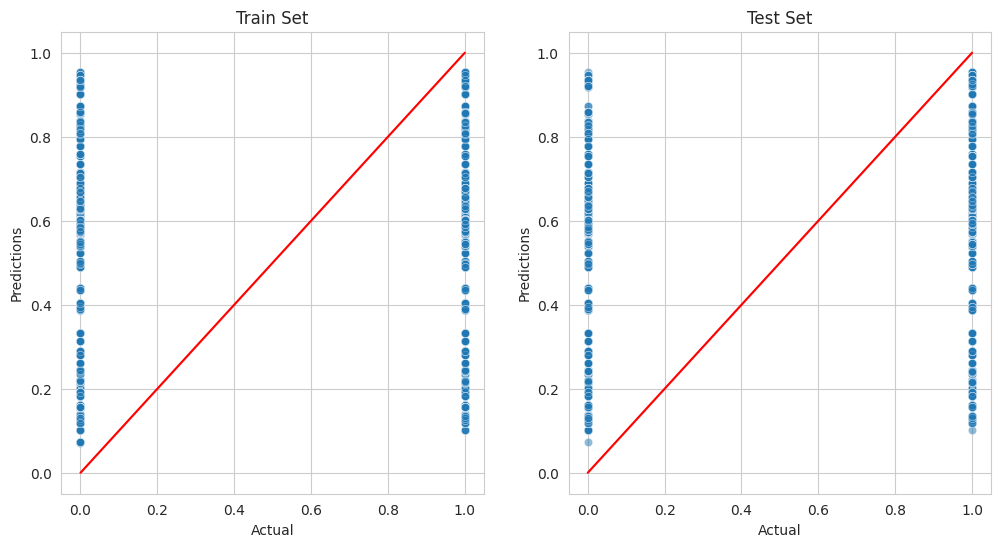

In [14]:
def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### Regressor with PCA